In [1]:
from dataclasses import asdict, dataclass

import seaborn as sns
import torch
import wandb
from contextual_distros import ContextualGMM
from control_function import ControlFunction, TestEncoder
from dvi_process import CMCD, DIS
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
from train import train
from context_datasets import ContextTestDataset

In [2]:
import torch_directml

device = torch.device("cpu") 
# device  = torch_directml.device()

In [3]:
@dataclass
class Config():
    num_steps = 16
    c_dim = 1
    z_dim = 1
    h_dim = 32
    num_layers = 3
    non_linearity = "SiLU"
    learning_rate = 3e-3
    size = 4096
    batch_size = 4096

config = Config()

In [ ]:
dataset = ContextTestDataset(size=config.size, c_dim=config.c_dim, sampling_factor=0)
dataloader = DataLoader(dataset=dataset, batch_size=config.batch_size, shuffle=True)

In [5]:
set_encoder = TestEncoder(
    c_dim=config.c_dim, 
    h_dim=config.h_dim
)

control_function = ControlFunction(
    h_dim=config.h_dim, 
    z_dim=config.z_dim, 
    num_layers=config.num_layers, 
    non_linearity=config.non_linearity, 
    num_steps=config.num_steps,
    set_encoder=set_encoder
)

dvi_process = DIS(
    device=device, 
    z_dim=config.z_dim, 
    num_steps=config.num_steps, 
    control_function=control_function
).to(device)

In [6]:
target_constructor = lambda context: ContextualGMM(context, offsets=(5, -5), scales=(1, 1), weights=(0.3, 0.7))

In [7]:
wandb_logging = False
if wandb_logging:
    wandb.init(project="dvi-1d", config=asdict(config))

In [8]:
num_epochs = 1000
optimizer = torch.optim.Adam(params=dvi_process.parameters(), lr=config.learning_rate)

In [9]:
losses = train(
    dvi_process=dvi_process, 
    device=device,
    num_epochs=num_epochs, 
    dataloader=dataloader, 
    target_constructor=target_constructor,
    optimizer=optimizer,  
    wandb_logging=wandb_logging
)

100%|██████████| 1/1 [00:00<00:00, 15.17it/s, epoch=999, loss=19.4]


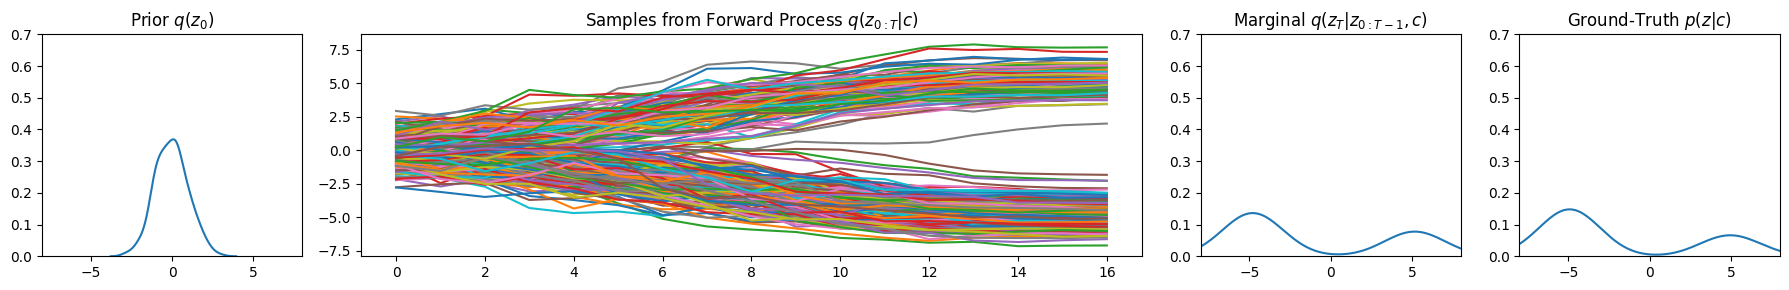

In [10]:
num_samples = 256

context = dataset.sampling_factor * torch.ones((num_samples, 1, config.c_dim), device=device)
p_z_T = target_constructor(context)
z_target_samples = p_z_T.sample()

dvi_process.eval()

# with torch.no_grad():
_, z_samples = dvi_process.run_chain(p_z_T, context.to(device))
z_0_samples = z_samples[0].detach().cpu().numpy()
z_T_samples = z_samples[-1].detach().cpu().numpy()
z_trajectories = [[z[i, :].detach().cpu().numpy() for z in z_samples] for i in range(num_samples)]

fig, ax = plt.subplots(1, 4, figsize=(18, 3), gridspec_kw={'width_ratios': [1, 3, 1, 1]})

sns.kdeplot(z_0_samples, ax=ax[0])
ax[0].set_title("Prior $q(z_0)$")
ax[0].set_ylabel(None)
ax[0].set_xlim(-8, 8)
ax[0].set_ylim(0, 0.7)
ax[0].get_legend().remove()

for i in range(num_samples):
    ax[1].plot(z_trajectories[i])
ax[1].set_title("Samples from Forward Process $q(z_{0:T}|c)$")

sns.kdeplot(z_T_samples, ax=ax[2])
ax[2].set_title("Marginal $q(z_T|z_{0:T-1},c)$")
ax[2].set_ylabel(None)
ax[2].set_xlim(-8, 8)
ax[2].set_ylim(0, 0.7)
ax[2].get_legend().remove()

sns.kdeplot(z_target_samples, ax=ax[3])
ax[3].set_title("Ground-Truth $p(z|c)$")
ax[3].set_ylabel(None)
ax[3].set_xlim(-8, 8)
ax[3].set_ylim(0, 0.7)
ax[3].get_legend().remove()

plt.tight_layout()
plt.show()